In [51]:
import sys
sys.executable

'/usr/local/opt/python@3.9/bin/python3.9'

In [58]:
import cv2
import random
from subprocess import call
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Part 1 - Segmentation

In [36]:
image_path = 'segmentation/call.png'

In [37]:
def process_image(image_path):
    # 01 - Load the image
    img = cv2.imread(image_path)
    # 02 - Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
    # 03 - Apply thresholding to convert the image to binary
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 04 - Perform connected component analysis to separate the characters
    connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    # 05 - Extract characters
    chars = _process_characters(connected_components_output)
    return chars

In [38]:
def _process_characters(connected_components_output):
    num_labels, labels, stats, centroids = connected_components_output
    # Get the number of characters (excluding the background)
    num_chars = num_labels - 1
    # Define a list to store individual characters
    chars = []
    # Define a list to store the coordinates of each character
    coords = []
    # Loop through each character
    for i in range(num_chars):
        # Extract the character by cropping the image
        char = labels == i + 1
        char = char.astype(np.uint8) * 255

        # Store the character and its coordinates
        chars.append(char)
        coords.append(stats[i+1][:2])
    # Sort the characters based on their x-coordinates (from right to left)
    chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]
    assert len(chars) == num_chars
    return chars

In [39]:
chars = process_image('segmentation/call.png')

In [72]:
len(chars)

8

In [81]:
chars_hello = process_image('segmentation/hello.png')

In [82]:
len(chars_hello)

4

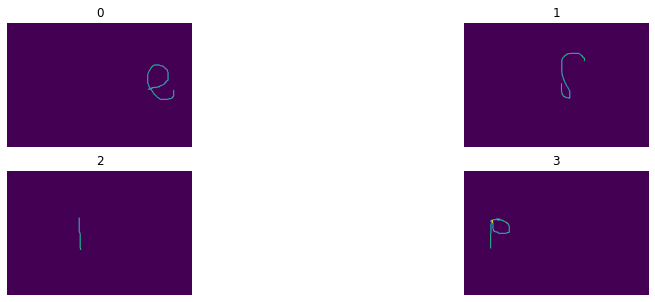

In [83]:
fig, axes = plt.subplots(2, len(chars_hello)//2, sharex=True, sharey=True, figsize=(15, 5))

for (i, img), ax in zip(enumerate(chars_hello), axes.flat):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(i)

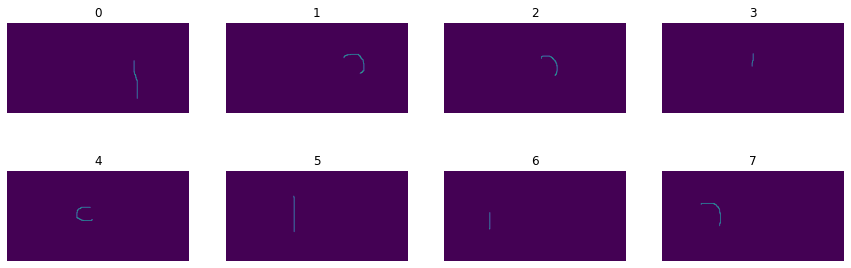

In [9]:
fig, axes = plt.subplots(2, len(chars)//2, sharex=True, sharey=True, figsize=(15, 5))

for (i, img), ax in zip(enumerate(chars), axes.flat):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(i)

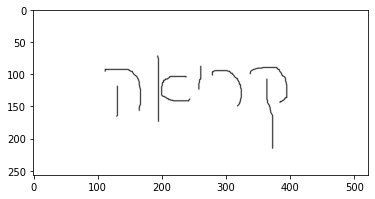

In [54]:
plt.imshow(cv2.imread(image_path));

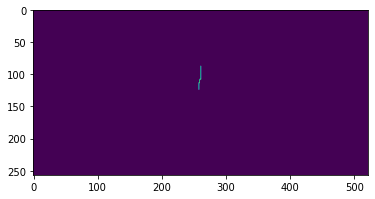

In [57]:
plt.imshow(chars[3])

# Part 2 - Classification

In [40]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
# from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from PIL import Image
# from keras.models import load_model
# from keras.preprocessing import image
import numpy as np

2023-06-10 18:21:24.183804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
# prepare a list of image files to be loaded
def image_files(input_directory):
    filepaths = []
    labels = []

    digit_folders = os.listdir(input_directory)
    # print(digit_folders)

    for digit in digit_folders:
        path = os.path.join(input_directory, digit)
        flist = os.listdir(path)
        for f in flist:
            fpath = os.path.join(path, f)
            filepaths.append(fpath)
            labels.append(digit)
    return filepaths, labels


def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = load_img(filepaths[i], target_size=(32, 32, 3), grayscale=False)
        img = img_to_array(img)
        img.astype('float32')
        img = img / 255
        images.append(img)

    images = np.array(images)
    return images

In [42]:
DATA_DIR_TRAIN = r'/Users/stav/Projects/CodeSH/vgg_for_final_project/TRAIN'
SEED           = 42
EPOCHS         = 4


def load_vgg_model():
    vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(32, 32, 3)
              )
    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(28, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model


def train_model(model):
    # load the paths and labels in differnt variables
    filepaths, labels = image_files(DATA_DIR_TRAIN) # 5,099 files
    print(f'Using {len(filepaths):,} files for training.')
    # load the 10K images
    images = load_images(filepaths)
    y = to_categorical(labels, num_classes=28)
    X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=SEED, test_size=0.2)
    print('X_train.shape:', X_train.shape)
    print('X_test.shape:',  X_test.shape)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=128,
        validation_data=(X_test, y_test)
    )
    return history

In [43]:
model = load_vgg_model()
model.summary()

2023-06-10 18:21:34.536737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 28)                14364     
                                                                 
Total params: 20,038,748
Trainable params: 20,038,748
Non-trainable params: 0
_________________________________________________________________


## Part 2.1 - Model Training & Evaluation

In [50]:
history = train_model(model)

Using 5,099 files for training.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5099/5099 [00:04<00:00, 1196.22it/s]


X_train.shape: (4079, 32, 32, 3)
X_test.shape: (1020, 32, 32, 3)
Epoch 1/4
32/32 [==============================] - 94s 3s/step - loss: 2.7922 - accuracy: 0.2233 - val_loss: 1.9415 - val_accuracy: 0.4353
Epoch 2/4
32/32 [==============================] - 98s 3s/step - loss: 1.5020 - accuracy: 0.5712 - val_loss: 0.9192 - val_accuracy: 0.7451
Epoch 3/4
32/32 [==============================] - 96s 3s/step - loss: 0.8177 - accuracy: 0.7575 - val_loss: 0.7796 - val_accuracy: 0.7755
Epoch 4/4
32/32 [==============================] - 105s 3s/step - loss: 0.6251 - accuracy: 0.8166 - val_loss: 0.7646 - val_accuracy: 0.7618


In [22]:
model

In [24]:
# load the paths and labels in differnt variables
filepaths, labels = image_files(DATA_DIR_TRAIN) # 5,099 files
print(f'Using {len(filepaths):,} files for training.')
# load the 10K images
images = load_images(filepaths)
y = to_categorical(labels, num_classes=28)
X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=SEED, test_size=0.2)

Using 5,099 files for training.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5099/5099 [00:04<00:00, 1247.16it/s]


# Part 3 - Word Correction

In [90]:
model_output = "שלוםם"

In [91]:
model_output in words

False

In [95]:
from tqdm import tqdm

In [101]:
# min_lev_dist = 1000
closest_words = []
for word in tqdm(words):
    lev_dist_word = lev_dist(model_output, word)
    if lev_dist_word == 1:
        # min_lev_dist = lev_dist_word
        closest_words.append(word)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469509/469509 [00:21<00:00, 22246.42it/s]


In [99]:
min_lev_dist

1

In [102]:
closest_words

['שלוום', 'שלוחם', 'שלום', 'שלומם', 'שלותם', 'שלוכם']

In [1]:
WORDS_FILENAME = "all_append_fatverb.txt"

In [23]:
words = open(WORDS_FILENAME).read().splitlines()

In [24]:
print(f'Number of words: {len(words):,}')

Number of words: 469,509


In [65]:
for _ in range(5):
    print(random.choice(words))

צלופחי
נערכי
תהגני
מכחישתן
עירויו


In [ ]:
אאביק

In [66]:
indices = [28872, 186472, 306417, 316132]
print(', '.join([words[idx] for idx in indices]))

בינה, מלאכותית, שלום, תודה


In [67]:
'שלום' in words, 'שלים' in words

(True, True)